# handling outlier

In [27]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
df = pd.DataFrame(data)
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [28]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


## Z-score Method

<Axes: xlabel='RM'>

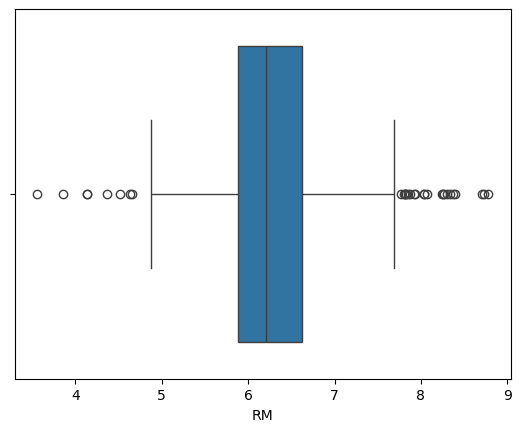

In [33]:
import seaborn as sns

sns.boxplot(x=df['RM'])

In [35]:
from scipy.stats import zscore
df["z_score"] = zscore(df['RM'])
threshold = 3
outliers_z = df[abs(df["z_score"]) > threshold]
clean_df =  df[abs(df["z_score"]) < threshold]

In [37]:
outliers_z

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,z_score
225,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,50.0,3.476688
257,0.61154,20.0,3.97,0.0,0.647,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12,50.0,3.446770
262,0.52014,20.0,3.97,0.0,0.647,8.398,91.5,2.2885,5.0,264.0,13.0,386.86,5.91,48.8,3.010825
364,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9,3.555044
365,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,-3.880249
367,13.52220,0.0,18.10,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1,-3.450002
374,18.49820,0.0,18.10,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97,13.8,-3.058221
406,20.71620,0.0,18.10,0.0,0.659,4.138,100.0,1.1781,24.0,666.0,20.2,370.22,23.34,11.9,-3.058221


<Axes: xlabel='RM'>

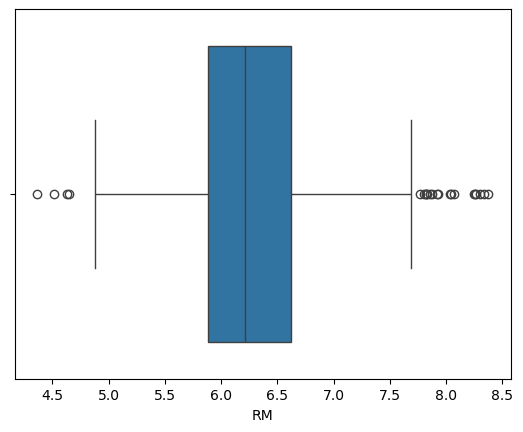

In [36]:
sns.boxplot(x=clean_df['RM'])

## Interquartile Range (IQR)

In [42]:
Q1, Q3 = df['RM'].quantile([0.25, 0.75])

IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['RM'] < lower_bound) | (df['RM'] > upper_bound)]
outliers_iqr.head(5)
clean_df_iqr = df[(df['RM'] > lower_bound) & (df['RM'] < upper_bound)]

<Axes: xlabel='RM'>

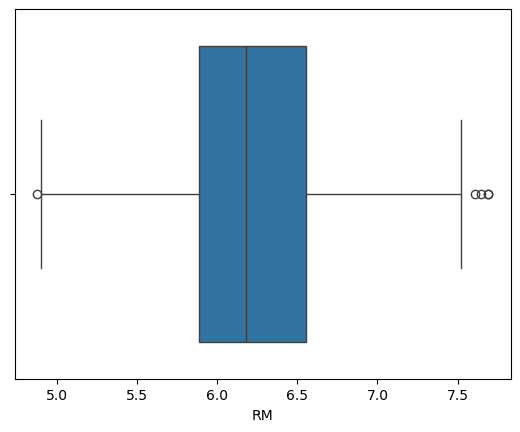

In [43]:
sns.boxplot(x=clean_df_iqr['RM'])

## Isolation Forest

In [47]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05)
df['anomaly_if'] = iso.fit_predict(df[['RM', 'MEDV']])
outliers_if = df[df['anomaly_if'] == -1]
clean_df_if = df[df['anomaly_if'] != -1]
outliers_if.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,z_score,anomaly_if
97,0.12083,0.0,2.89,0.0,0.445,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7,2.542112,-1
163,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0,2.978058,-1
180,0.06588,0.0,2.46,0.0,0.488,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8,2.109016,-1
224,0.31533,0.0,6.20,0.0,0.504,8.266,78.3,2.8944,8.0,307.0,17.4,385.05,4.14,44.8,2.822770,-1
225,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,50.0,3.476688,-1


<Axes: xlabel='RM'>

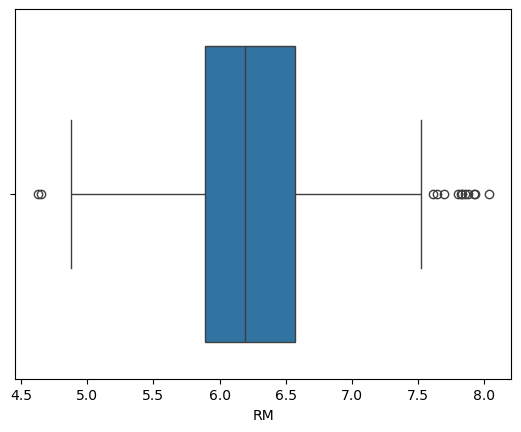

In [49]:
sns.boxplot(x=clean_df_if['RM'])

## Local Outlier Factor (LOF)

In [54]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
df['anomaly_lof'] = lof.fit_predict(df[['RM', 'MEDV']])
outliers_lof = df[df['anomaly_lof'] == -1]
clean_df_lof = df[df['anomaly_lof'] != -1]
outliers_lof.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,z_score,anomaly_if,anomaly_lof
184,0.08308,0.0,2.46,0.0,0.488,5.604,89.8,2.9879,3.0,193.0,17.8,391.00,13.98,26.4,-0.969672,1,-1
214,0.28955,0.0,10.59,0.0,0.489,5.412,9.8,3.5875,4.0,277.0,18.6,348.93,29.55,23.7,-1.243206,1,-1
249,0.19073,22.0,5.86,0.0,0.431,6.718,17.5,7.8265,7.0,330.0,19.1,393.74,6.56,26.2,0.617398,1,-1
362,3.67822,0.0,18.10,0.0,0.770,5.362,96.2,2.1036,24.0,666.0,20.2,380.79,10.19,20.8,-1.314439,1,-1
364,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9,3.555044,-1,-1
365,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,-3.880249,-1,-1
366,3.69695,0.0,18.10,0.0,0.718,4.963,91.4,1.7523,24.0,666.0,20.2,316.03,14.00,21.9,-1.882878,1,-1
367,13.52220,0.0,18.10,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1,-3.450002,-1,-1
374,18.49820,0.0,18.10,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97,13.8,-3.058221,-1,-1
406,20.71620,0.0,18.10,0.0,0.659,4.138,100.0,1.1781,24.0,666.0,20.2,370.22,23.34,11.9,-3.058221,-1,-1


<Axes: xlabel='RM'>

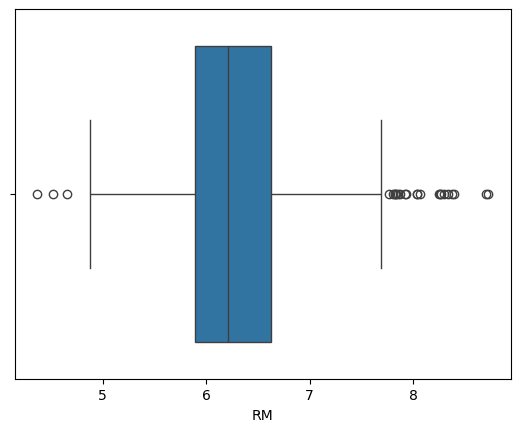

In [55]:
sns.boxplot(x=clean_df_lof['RM'])

## Mahalanobis Distance

In [56]:
import numpy as np
from scipy.spatial import distance

def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

data = df[['RM', 'MEDV']]
cov_matrix = np.cov(data.values.T)
df['mahal_dist'] = mahalanobis(data, data, cov_matrix)

threshold = 15  # empirical
outliers_mahal = df[df['mahal_dist'] > threshold]
cleandf_mahal = df[df['mahal_dist'] < threshold]
outliers_mahal.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,z_score,anomaly_if,anomaly_lof,mahal_dist
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,0.413672,1,1,274.099849
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,0.194274,1,1,275.361142
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,1.282714,1,1,275.164779
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,1.016303,1,1,282.295801
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,1.228577,1,1,283.628790


<Axes: >

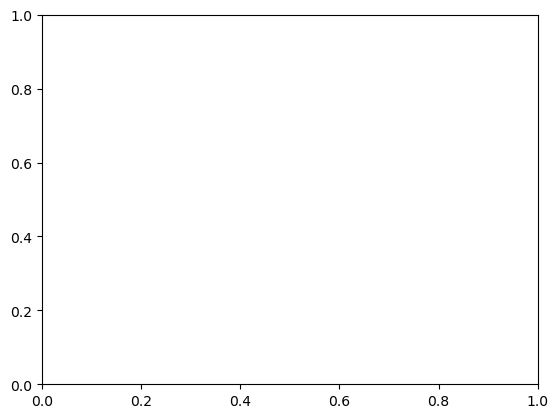

In [57]:
sns.boxplot(x=cleandf_mahal['RM'])